# Entropy as a Predictor for Intraday Volatility in FX

We consider entropy as an estimator of intraday volatility. 'True' volatility is calculated as the 15 minute returns standard deviation across the day, whilst entropy is calculated using the same data - where we aim to estimate the volatility for the following day. This is done as opposed to estimates based on a rolling window.

Various entropy measures and predictive relationships are explored between entropy and volatility. We consider a GARCH + entropy measurement, linear regression, then non linear estimates based on decision trees, gradient boosting trees.

Given the volatility is not actually observed, we also apply our best estimator within a Kalman filter to attempt to form better estimates.

We initially use EURUSD data, then extend to other currency pairs. We begin working on low frequency data, looking later at higher frequency data to see if the model atill holds, taking advantage of the use of neural networks where we not have more data.
As an extension, we use mutual information as a way to estimate currency pair correlation, and hence the 'driving currency' of volatility. This could in theory be used to predict covariance matrices maybe?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

In [2]:
path = 'C:/Users/camer/OneDrive/Documents/dev/home_research/data/volatility_entropy_project_fx/'

## 15-min data

In [11]:
eurusd_data = pd.read_csv(path + 'EURUSD-2000-2020-15m.csv')[['DATE_TIME', 'CLOSE']]
eurusd_data

,DATE_TIME,CLOSE
0,2000.01.03 00:00:00,1.00770
1,2000.01.03 00:15:00,1.00860
2,2000.01.03 00:30:00,1.00790
3,2000.01.03 00:45:00,1.01280
4,2000.01.03 01:00:00,1.01220
...,...,...
500746,2020.03.19 05:00:00,1.08895
500747,2020.03.19 05:15:00,1.08872
500748,2020.03.19 05:30:00,1.09086
500749,2020.03.19 05:45:00,1.08970


In [16]:
eurusd_data['ret'] = np.log(eurusd_data['CLOSE']/eurusd_data['CLOSE'].shift())
eurusd_data['ret_sqd'] = eurusd_data['ret']**2

In [17]:
eurusd_data['date'] = pd.to_datetime(eurusd_data['DATE_TIME']).dt.date

In [18]:
eurusd_data

,DATE_TIME,CLOSE,date,ret,ret_sqd
0,2000.01.03 00:00:00,1.00770,2000-01-03,NaN,NaN
1,2000.01.03 00:15:00,1.00860,2000-01-03,0.000893,7.969568e-07
2,2000.01.03 00:30:00,1.00790,2000-01-03,-0.000694,4.820140e-07
3,2000.01.03 00:45:00,1.01280,2000-01-03,0.004850,2.352070e-05
4,2000.01.03 01:00:00,1.01220,2000-01-03,-0.000593,3.511660e-07
...,...,...,...,...,...
500746,2020.03.19 05:00:00,1.08895,2020-03-19,0.000854,7.299970e-07
500747,2020.03.19 05:15:00,1.08872,2020-03-19,-0.000211,4.462020e-08
500748,2020.03.19 05:30:00,1.09086,2020-03-19,0.001964,3.856046e-06
500749,2020.03.19 05:45:00,1.08970,2020-03-19,-0.001064,1.131983e-06


In [19]:
daily_vol_eurusd = eurusd_data[['date', 'ret_sqd']].groupby('date').sum().rename({'ret_sqd': 'vol'}, axis=1)

<Axes: xlabel='date'>

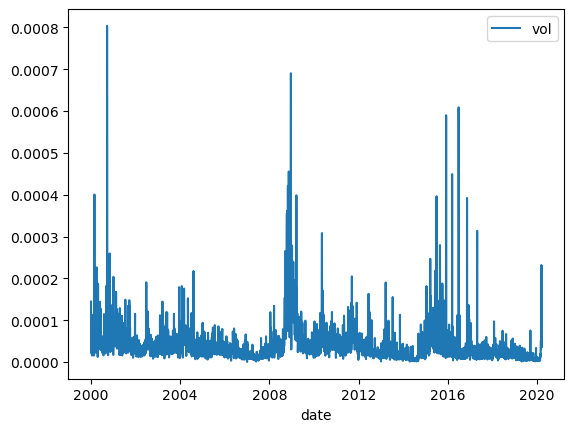

In [20]:
daily_vol_eurusd.plot()

In [21]:
from helper_functions.afml_functions.afml_modelling_lib import encode_and_entropy

In [222]:
daily_entropy_eurusd = eurusd_data[['date', 'ret']].groupby('date').apply(lambda x: encode_and_entropy(x['ret'], 10, 3)) #.rename({'ret': 'entropy'}, axis=1)

KeyError: "['ret'] not in index"

<Axes: xlabel='date'>

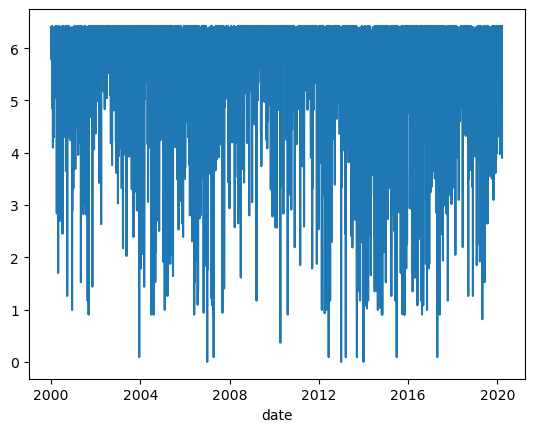

In [51]:
daily_entropy_eurusd.plot()

In [22]:
import statsmodels.api as sm

In [23]:
eurusd_data = eurusd_data.drop('DATE_TIME', axis=1)

In [24]:
eurusd_data

,CLOSE,date,ret,ret_sqd
0,1.00770,2000-01-03,NaN,NaN
1,1.00860,2000-01-03,0.000893,7.969568e-07
2,1.00790,2000-01-03,-0.000694,4.820140e-07
3,1.01280,2000-01-03,0.004850,2.352070e-05
4,1.01220,2000-01-03,-0.000593,3.511660e-07
...,...,...,...,...
500746,1.08895,2020-03-19,0.000854,7.299970e-07
500747,1.08872,2020-03-19,-0.000211,4.462020e-08
500748,1.09086,2020-03-19,0.001964,3.856046e-06
500749,1.08970,2020-03-19,-0.001064,1.131983e-06


In [27]:
eurusd_data_daily = eurusd_data.groupby('date').tail(1)
eurusd_data_daily['ret_bps'] = 1e4*np.log(eurusd_data_daily['CLOSE']/eurusd_data_daily['CLOSE'].shift())
eurusd_data_daily

C:\Users\camer\AppData\Local\Temp\ipykernel_62276\878831192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eurusd_data_daily['ret_bps'] = 1e4*np.log(eurusd_data_daily['CLOSE']/eurusd_data_daily['CLOSE'].shift())


,CLOSE,date,ret,ret_sqd,ret_bps
95,1.02460,2000-01-03,0.000488,2.382557e-07,NaN
189,1.02920,2000-01-04,0.000194,3.776981e-08,44.795089
285,1.03260,2000-01-05,0.000291,8.443149e-08,32.980920
381,1.03300,2000-01-06,0.000000,0.000000e+00,3.872967
477,1.02980,2000-01-07,-0.000097,9.428705e-09,-31.025815
...,...,...,...,...,...
500437,1.11023,2020-03-13,-0.000513,2.634516e-07,-57.659306
500533,1.11775,2020-03-16,-0.000018,3.201569e-10,67.505351
500629,1.10055,2020-03-17,0.000100,9.991006e-09,-155.076813
500725,1.09114,2020-03-18,0.000110,1.209621e-08,-85.870336


#### this low frequency data kinda seems worse
lets:
- re-look at how to calculate entropy
- re-look at how to calculate/estimate variance (just use r^2 or rolling value)
- then lets re-look at the estimators

In [28]:
from arch import arch_model

In [29]:
eurusd_data_daily

,CLOSE,date,ret,ret_sqd,ret_bps
95,1.02460,2000-01-03,0.000488,2.382557e-07,NaN
189,1.02920,2000-01-04,0.000194,3.776981e-08,44.795089
285,1.03260,2000-01-05,0.000291,8.443149e-08,32.980920
381,1.03300,2000-01-06,0.000000,0.000000e+00,3.872967
477,1.02980,2000-01-07,-0.000097,9.428705e-09,-31.025815
...,...,...,...,...,...
500437,1.11023,2020-03-13,-0.000513,2.634516e-07,-57.659306
500533,1.11775,2020-03-16,-0.000018,3.201569e-10,67.505351
500629,1.10055,2020-03-17,0.000100,9.991006e-09,-155.076813
500725,1.09114,2020-03-18,0.000110,1.209621e-08,-85.870336


In [252]:
eurusd_ret = eurusd_data_daily['ret_bps'].dropna()
eurusd_ret.index = pd.to_datetime(eurusd_ret.index)

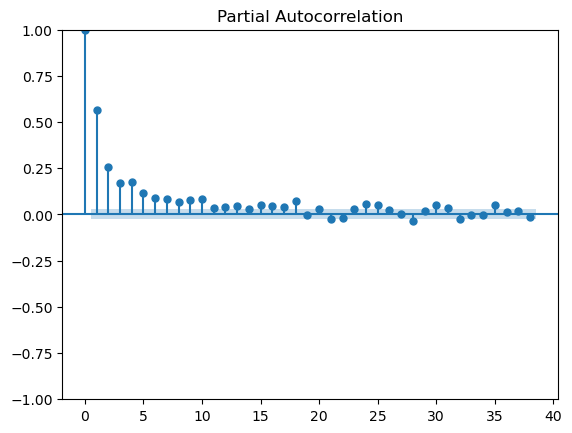

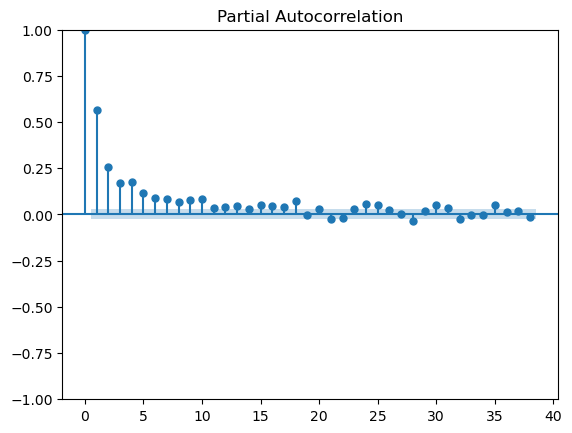

In [32]:
from statsmodels.tsa.stattools import pacf
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(future_vol)

In [64]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

ModuleNotFoundError: No module named 'statsmodels.api.tsa'; 'statsmodels.api' is not a package

- set a benchmark based omn AR model
- find somehighe frequency dfaat
- regress with entropy
- midas with entropy - check residuals etc in ols and midas
- nonlinar models

In [35]:
adfuller(future_vol)

(-4.714719213328281,
 7.895512875792945e-05,
 31,
 5222,
 {'1%': -3.431602875792823,
  '5%': -2.862093640802141,
  '10%': -2.567064702779875},
 -93411.96223789119)

Indicates TS is at least stationary

array([[<Axes: title={'center': 'vol'}>]], dtype=object)

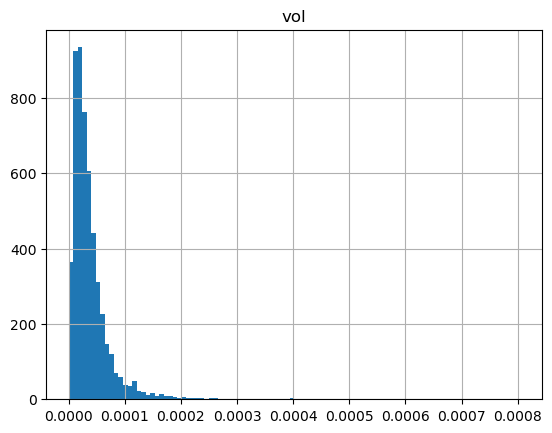

In [36]:
future_vol.hist(bins=100)

Distribution is skewed (right skewed) so extreme positive events are likely - lets do a long transform on this

In [68]:
log_future_vol = pd.DataFrame(np.log(future_vol))

Much better

## Benchmark model (ARMA)

In [78]:
arma_model1 = ARIMA(log_future_vol, order=(2, 0, 1))
res1 = arma_model1.fit()
res1.summary()

C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    vol   No. Observations:                 5254
Model:                 ARIMA(2, 0, 1)   Log Likelihood               -3729.314
Date:                Sun, 24 Nov 2024   AIC                           7468.629
Time:                        23:14:30   BIC                           7501.462
Sample:                             0   HQIC                          7480.107
                               - 5254                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4529      0.147    -71.259      0.000     -10.740     -10.165
ar.L1          1.1207      0.016     69.423      0.000       1.089       1.152
ar.L2         -0.1277      0.016     -8.129      0.000      -0.158      -0.097
ma.L1         -0.8508      0.009    -93.435      0.000      -0.869      -0.833
sigma2         0.2420      0.003     79.251      0.000       0.236       0.248
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2199.99
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.55   Skew:                             0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
arma_model2 = ARIMA(log_future_vol, order=(1, 0, 1))
res2 = arma_model2.fit()
res2.summary()

C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    vol   No. Observations:                 5254
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3754.254
Date:                Sun, 24 Nov 2024   AIC                           7516.509
Time:                        11:52:20   BIC                           7542.776
Sample:                             0   HQIC                          7525.692
                               - 5254                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4587      0.124    -84.453      0.000     -10.701     -10.216
ar.L1          0.9882      0.002    430.896      0.000       0.984       0.993
ma.L1         -0.7902      0.009    -92.388      0.000      -0.807      -0.773
sigma2         0.2444      0.003     78.597      0.000       0.238       0.250
===================================================================================
Ljung-Box (L1) (Q):                  27.34   Jarque-Bera (JB):              2091.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.56   Skew:                             0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
res2.forecast()

C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


5254   -9.521388
dtype: float64

In [40]:
log_future_vol

,vol
date,
2000-01-04,-9.619532
2000-01-05,-9.593818
2000-01-06,-9.826425
2000-01-07,-9.812373
2000-01-10,-10.441778
...,...
2020-03-13,-9.055258
2020-03-16,-8.599058
2020-03-17,-9.449374


Based om AIC/BIC cirterions, pick the ARMA(2, 1) model

In [41]:
res2.predict()

date
2000-01-04   -10.458747
2000-01-05    -9.877182
2000-01-06    -9.764956
2000-01-07    -9.792546
2000-01-10    -9.805648
                ...    
2020-03-13    -9.594473
2020-03-16    -9.497856
2020-03-17    -9.331165
2020-03-18    -9.367843
2020-03-19    -9.330924
Name: predicted_mean, Length: 5254, dtype: float64

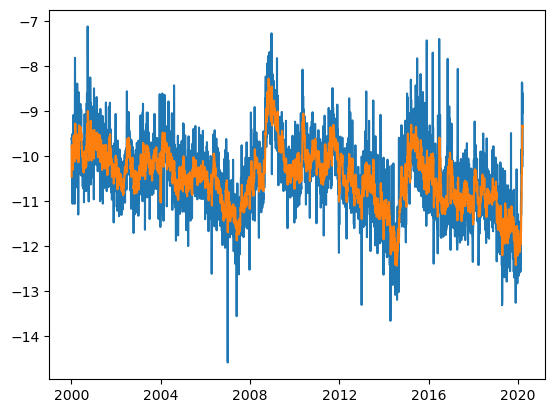

In [42]:
plt.plot(log_future_vol, label='actual')
plt.plot(res2.predict(), label='prediction')

In [74]:
log_future_vol_train

,vol
date,
2000-01-04,-9.619532
2000-01-05,-9.593818
2000-01-06,-9.826425
2000-01-07,-9.812373
2000-01-10,-10.441778
...,...
2019-03-21,-11.313864
2019-03-22,-10.141469
2019-03-25,-11.560825


In [103]:
log_future_vol_test #.dropna()

,vol
5000,-11.056440
5001,-11.610383
5002,-11.969470
5003,-12.097270
5004,-11.666269
...,...
5249,-9.055258
5250,-8.599058
5251,-9.449374
5252,-9.116603


In [147]:
log_future_train_intind = log_future_vol.reset_index(drop=True)
log_future_vol_train = log_future_train_intind.iloc[:5000]
log_future_vol_test = log_future_train_intind.iloc[5000:]

arma_model = ARIMA(log_future_vol_train, order=(1, 0, 1))
res = arma_model.fit()
print(res.summary())

res= res.extend(log_future_vol_test)

res.predict()

                               SARIMAX Results                                
Dep. Variable:                    vol   No. Observations:                 5000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3530.018
Date:                Sat, 30 Nov 2024   AIC                           7068.036
Time:                        09:08:27   BIC                           7094.104
Sample:                             0   HQIC                          7077.172
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4312      0.115    -90.353      0.000     -10.657     -10.205
ar.L1          0.9880      0.002    413.185      0.000       0.983       0.993
ma.L1         -0.8031      0.009    -90.786      0.0

5000   -11.198826
5001   -11.163310
5002   -11.237262
5003   -11.363077
5004   -11.487755
          ...    
5249    -9.643605
5250    -9.544182
5251    -9.379948
5252    -9.405357
5253    -9.364204
Name: predicted_mean, Length: 254, dtype: float64

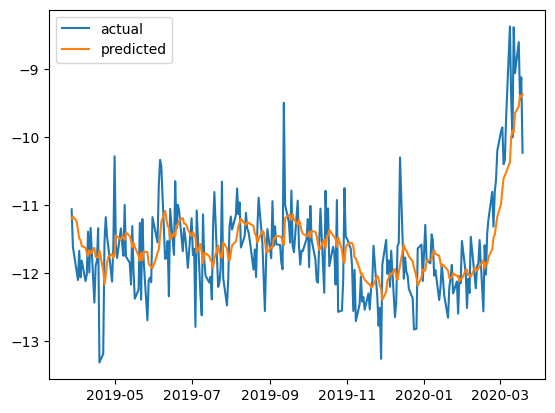

In [148]:
predicted = res.predict()
predicted.index = log_future_vol.iloc[5000:].index
actual = log_future_vol.iloc[5000:]

plt.plot(actual, label='actual')
plt.plot(predicted, label='predicted')
plt.legend()
plt.show()

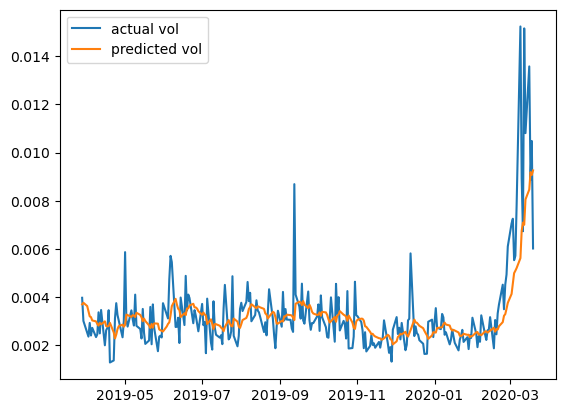

In [149]:
# transform back to std and find mse
def vol_inverse_transform(log_var):
    return np.sqrt(np.exp(log_var))

actual_vol = vol_inverse_transform(actual)
predicted_vol = vol_inverse_transform(predicted)
plt.plot(actual_vol, label='actual vol')
plt.plot(predicted_vol, label='predicted vol')
plt.legend()
plt.show()

In [150]:
mse = np.mean((actual_vol['vol'] - predicted_vol)**2)
mse

1.6593533298394577e-06

## Benchmark + Entropy Exog (can we beat it?)

In [112]:
import itertools
best_rsqd = 0
best_qL = (2, 10)
for q, L in itertools.product([9, 10, 11], [14, 15, 16]):
    entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()
    mod = sm.OLS(eurusd_data[['date', 'ret_sqd']].set_index('date').groupby('date').mean().iloc[1:], entropy_prev_day.dropna())
    res = mod.fit()
    print(q, L, res.rsquared)
    best_rsqd = max(res.rsquared, best_rsqd)
    if res.rsquared == best_rsqd:
        best_qL = (q, L)
print(best_qL, best_rsqd)

C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


9 14 0.4617601460835684


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


9 15 0.4617245026330411


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


9 16 0.4616948983285756


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


10 14 0.4615159218790462


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


10 15 0.46148929273745165


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


10 16 0.46146859255463923


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


11 14 0.4616137659222499


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


11 15 0.4615764429988596
11 16 0.4615365561130784
(9, 14) 0.4617601460835684


C:\Users\camer\AppData\Local\Temp\ipykernel_62276\1932594217.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


In [116]:
L = 14 # length of the pattern
q = 3 # despite tests above, 9 will like be too much, lets just stick with 3 for now
entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()

C:\Users\camer\AppData\Local\Temp\ipykernel_62276\660271669.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()


In [117]:
entropy_prev_day

date
2000-01-03         NaN
2000-01-04    6.191702
2000-01-05    6.321928
2000-01-06    6.357552
2000-01-07    6.333162
                ...   
2020-03-13    5.928049
2020-03-16    6.285402
2020-03-17    6.357552
2020-03-18    6.357552
2020-03-19    5.960853
Length: 5255, dtype: float64

In [151]:
entropy_prev_day = pd.DataFrame(entropy_prev_day, columns=['entropy']).dropna()
log_future_vol_entropy_ind = log_future_vol.loc[entropy_prev_day.index]
log_future_train_intind = log_future_vol_entropy_ind.reset_index(drop=True)
entropy_prev_day_intind = entropy_prev_day.reset_index(drop=True)

log_future_vol_train = log_future_train_intind.iloc[:5000]
log_future_vol_test = log_future_train_intind.iloc[5000:]
entropy_prev_day_train = entropy_prev_day_intind.iloc[:5000]
entropy_prev_day_test = entropy_prev_day_intind.iloc[5000:]

arma_entropy_model = ARIMA(log_future_vol_train, exog=entropy_prev_day_train, order=(1, 0, 1))
res_entropy = arma_entropy_model.fit()
print(res_entropy.summary())

res_entropy = res_entropy.extend(log_future_vol_test, exog=entropy_prev_day_test)

res_entropy.predict()

                               SARIMAX Results                                
Dep. Variable:                    vol   No. Observations:                 5000
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -3527.524
Date:                Sat, 30 Nov 2024   AIC                           7065.047
Time:                        09:08:47   BIC                           7097.633
Sample:                             0   HQIC                          7076.468
                               - 5000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.5359      0.120    -87.644      0.000     -10.772     -10.300
entropy        0.0175      0.007      2.460      0.014       0.004       0.031
ar.L1          0.9876      0.002    404.711      0.0

5000   -11.180126
5001   -11.148364
5002   -11.226665
5003   -11.360032
5004   -11.482169
          ...    
5249    -9.635122
5250    -9.529728
5251    -9.364615
5252    -9.393684
5253    -9.361325
Name: predicted_mean, Length: 254, dtype: float64

Using exog appears to be worse for the AIC/BIC even when we take out the AR2 parameter, lets see how it performs out of sample

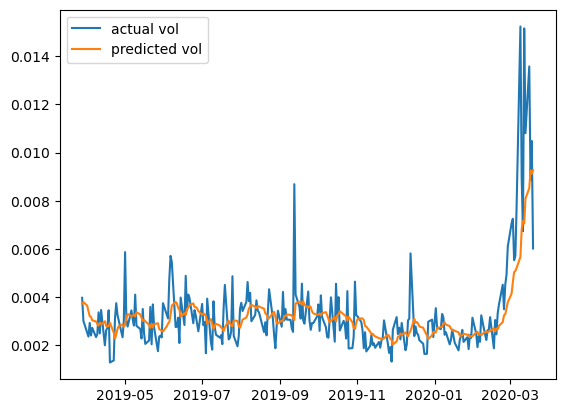

In [152]:
predicted_entropy = res_entropy.predict()
predicted_entropy.index = log_future_vol_entropy_ind.iloc[5000:].index
actual = log_future_vol_entropy_ind.iloc[5000:]

actual_vol = vol_inverse_transform(actual)
predicted_vol_entropy = vol_inverse_transform(predicted_entropy)
plt.plot(actual_vol, label='actual vol')
plt.plot(predicted_vol_entropy, label='predicted vol')
plt.legend()
plt.show()

In [153]:
mse = np.mean((actual_vol['vol'] - predicted_vol_entropy)**2)
mse

1.644505321888658e-06

In [154]:
100*(1.6593533298394577e-06 - 1.644505321888658e-06)/1.6593533298394577e-06

0.8948068915639646

entropy does beat the OOS benchmark for ARMA(1, 1), which is the best performing model both with and without antropy as an exogeneous variable. Adding entropy as an exogeneous variable to this model does have some predictive power, reducing the OOS MSE, giving a 0.89% improvement.

## Linear modelling